In [47]:
from scipy.stats import bernoulli
from scipy.stats import beta
from scipy.stats import uniform 
import math

DEFAULT_TEST_ROUNDS = 20000

In [48]:
class Arm:
    
    def __init__(self, q):
        self.quality     = q
        self.num_pulled  = 0
        self.num_rewards = 0
    
    def pullthisarm(self):
        reward = bernoulli.rvs(size=1,p=self.quality)[0]
        self.num_pulled +=1
        self.num_rewards += reward
        return reward

class Envi:
    
    def __init__(self, num_rounds):
        self.arms = []
        self.total_rounds = num_rounds
        
        self.best_arm = None
        self.cumul_regret = 0
        self.cumul_regret_at_round = []
        
        self.best_arm_unseen = None
        self.cumul_regret_unseen = 0
        self.cumul_regret_at_round_unseen = []
        
        self.hypo_exploration_count = 0
        self.total_pulls = 0
    
    def addArm(self, newArm):
        self.arms.append(newArm)
    
    def getQual(self, arm):
        return arm.quality
    
    def getBestArm(self):
        return self.best_arm
    
    def getNewArm(self):
        upper_limit = self.total_pulls / self.total_rounds
        qual = uniform.rvs(loc=0, scale=(1- upper_limit), size=1)[0]
        retArm = Arm(qual)
        return retArm
    
    #hyphothetical get new arm remains
    def getHypotheticalArm(self):
        upper_limit = self.hypo_exploration_count / self.total_rounds
        qual = uniform.rvs(loc=0, scale=(1- upper_limit), size=1)[0]
        retArm = Arm(qual)
        self.hypo_exploration_count += 1
        return retArm
        
        
    
    def pullNewArm(self):
        #qual = uniform.rvs(size=1)[0]
        #newArm = Arm(qual)
        newArm = self.getNewArm()
        self.addArm(newArm)
        self.best_arm = max(self.arms, key=self.getQual)
        self.best_arm_unseen = self.best_arm
        self.pull(newArm)
    
    def pull(self, arm):
        reward = arm.pullthisarm()
        self.total_pulls += 1
        self.cumul_regret += (self.best_arm.quality - arm.quality)
        self.cumul_regret_at_round.append(self.cumul_regret)
        
        self.best_arm_unseen = max(self.best_arm, self.getNewArm(), key=self.getQual)
        self.cumul_regret_unseen += (self.best_arm_unseen.quality - arm.quality)
        self.cumul_regret_at_round_unseen.append(self.cumul_regret_unseen)
        return reward

# Testing

In [49]:
def quickTest(envr, agent, rounds=DEFAULT_TEST_ROUNDS):
    e = Envi(rounds)
    ranAg = agent(e, rounds)
    ranAg.playFull()
    
    print("Number of rounds:", rounds)
    print("number of arms explored:", len(e.arms))
    print("Regret wrt explored arms", e.cumul_regret)
    #print("num pulls", list(map(lambda x: x.num_pulled, e.arms)))
    #print("num rewards", list(map(lambda x: x.num_rewards, e.arms)))
    #print("cumul_regret_at_round", e.cumul_regret_at_round)
    #print("count cumul_regret_at_round", len(e.cumul_regret_at_round))
    
    print("Regret wrt to unexplored arms", e.cumul_regret_unseen)
    
    
    import matplotlib.pyplot as plt
    time_hor = range(rounds)
    plt.plot(time_hor, e.cumul_regret_at_round)
    plt.plot(time_hor, e.cumul_regret_at_round_unseen)
    plt.xscale("log")
    plt.yscale("linear")
    
    return e.cumul_regret_at_round_unseen

# Agents

In [50]:
# Agent abstract class
class Agent:
    #pulls random arm with p = 0.5 or explores new arm with p = 0.5
    def __init__(self, envr, rounds):
        self.envr = envr
        self.total_rounds = rounds
        self.round = 0
        self.arm_pulled = []
        self.rewards = []
        self.total_reward = 0
        
    def playFull(self):
        for i in range(self.total_rounds):
            self.playRound()


## Random Agent

In [51]:
class RandomAgent(Agent):
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        #print(available_arms)
        ran = uniform.rvs(size=1)[0]
        if len(self.envr.arms) == 0 or ran > 0.5:
            self.envr.pullNewArm()
        else:
            ran2 = uniform.rvs(size=1)[0]
            index = int(ran2*(len(self.envr.arms)))
            #print("index", index)
            self.envr.pull(self.envr.arms[index])

Number of rounds: 20000
number of arms explored: 10080
Regret wrt explored arms 13498.26441173191
Regret wrt to unexplored arms 13498.84031206344


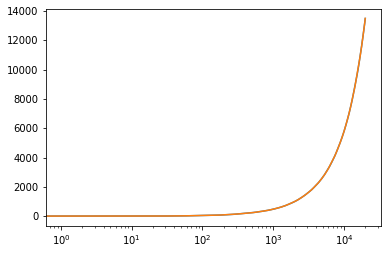

In [52]:
r_1_random = quickTest(1, RandomAgent)
#print (r_1_random)

## Always-New Agent

In [53]:
class AlwaysNewAgent(Agent):
    
    def playRound(self):
        self.round += 1
        self.envr.pullNewArm()

Number of rounds: 20000
number of arms explored: 20000
Regret wrt explored arms 14911.438823537912
Regret wrt to unexplored arms 14913.141337463088


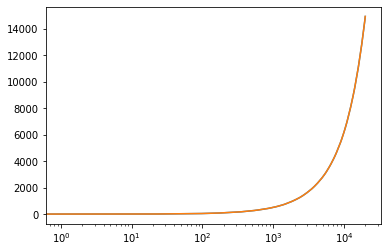

In [54]:
r_2_new = quickTest(1, AlwaysNewAgent)

## UCB Agent

In [55]:
class NaiveUCBAgent(Agent):
    def __init__(self, envr, rounds):
        Agent.__init__(self, envr, rounds)
        upper_conf_bound = []
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        
        if len(self.envr.arms) == 0 or uniform.rvs(size=1)[0] > 0.999:
            self.envr.pullNewArm()
        else:
            upper_conf_bound = [None] * len(available_arms)
            for i in range(len(available_arms)):
                s_i = available_arms[i].num_rewards
                n_i = available_arms[i].num_pulled
                a = (s_i/(n_i))
                b = (8 * math.log10(self.total_rounds+1))/(n_i)
                r = (a + math.sqrt(b))

                upper_conf_bound[i]=(r)
            
            max_smpl = max(upper_conf_bound)
            max_i = upper_conf_bound.index(max_smpl)
            self.envr.pull(self.envr.arms[max_i])

Number of rounds: 20000
number of arms explored: 25
Regret wrt explored arms 1161.1033153168685
Regret wrt to unexplored arms 1520.3383810962544


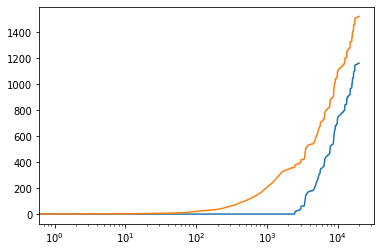

In [56]:
r_3_naive_ucb = quickTest(1, NaiveUCBAgent)

## Naive Thompson Sampling Agent

In [57]:
class NaiveTSAgent(Agent):
    def __init__(self, envr, rounds):
        Agent.__init__(self, envr, rounds)
        upper_conf_bound = []
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        
        if len(self.envr.arms) == 0 or uniform.rvs(size=1)[0] > 0.99:
            self.envr.pullNewArm()
        else:
            thm_smpl = [None] * len(available_arms)
            for i in range(len(available_arms)):
                s_i = available_arms[i].num_rewards
                n_i = available_arms[i].num_pulled
                a = s_i + 1
                b = n_i - s_i + 1
                
                #print("a,b", a, b)
                r = beta.rvs(a, b, size=1)
                thm_smpl[i]=r[0]
                
                #upper_conf_bound[i]=(r)
            
            max_smpl = max(thm_smpl)
            max_i = thm_smpl.index(max_smpl)
            self.envr.pull(self.envr.arms[max_i])

Number of rounds: 20000
number of arms explored: 197
Regret wrt explored arms 728.5158186030609
Regret wrt to unexplored arms 788.0285579694656


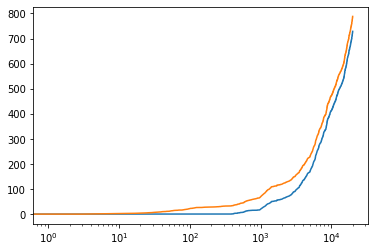

In [58]:
r_4_naive_ts = quickTest(1, NaiveTSAgent)

## Fair UCB

In [59]:
class FairUCBAgent(Agent):
    def __init__(self, envr, rounds):
        Agent.__init__(self, envr, rounds)
        upper_conf_bound = []
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        
        if len(self.envr.arms) == 0:
            self.envr.pullNewArm()
            return
        
        k = len(self.envr.arms)
        r = 0.01*(1/k)
        fairness_alpha = 0.9
        
        fair_pull_set = []
        for i in available_arms:
            fair_count = math.floor(r * self.total_rounds) - i.num_pulled
            if fair_count > fairness_alpha:
                fair_pull_set.append((i, fair_count))
        
        if fair_pull_set:
            max_smpl = max(fair_pull_set, key=lambda x: x[1])
            
        
        
        if uniform.rvs(size=1)[0] > 0.999:
            self.envr.pullNewArm()
        else:
            upper_conf_bound = [None] * len(available_arms)
            for i in range(len(available_arms)):
                s_i = available_arms[i].num_rewards
                n_i = available_arms[i].num_pulled
                a = (s_i/(n_i))
                b = (8 * math.log10(self.total_rounds+1))/(n_i)
                r = (a + math.sqrt(b))

                upper_conf_bound[i]=(r)
            
            max_smpl = max(upper_conf_bound)
            max_i = upper_conf_bound.index(max_smpl)
            self.envr.pull(self.envr.arms[max_i])

Number of rounds: 20000
number of arms explored: 20
Regret wrt explored arms 1359.1294704985944
Regret wrt to unexplored arms 1472.3375832851468


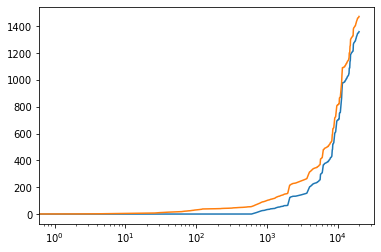

In [60]:
r_5_fair_ucb = quickTest(1, FairUCBAgent)

## Fair Thompson Sampling Agent

In [61]:
class FairTSAgent(Agent):
    def __init__(self, envr, rounds):
        Agent.__init__(self, envr, rounds)
        upper_conf_bound = []
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        
        if len(self.envr.arms) == 0:
            self.envr.pullNewArm()
            return
        
        k = len(self.envr.arms)
        r = 0.01*(1/k)
        fairness_alpha = 0.9
        
        fair_pull_set = []
        for i in available_arms:
            fair_count = math.floor(r * self.total_rounds) - i.num_pulled
            if fair_count > fairness_alpha:
                fair_pull_set.append((i, fair_count))
        
        if fair_pull_set:
            max_smpl = max(fair_pull_set, key=lambda x: x[1])
            
        
        
        if uniform.rvs(size=1)[0] > 0.99:
            self.envr.pullNewArm()
        else:
            thm_smpl = [None] * len(available_arms)
            for i in range(len(available_arms)):
                s_i = available_arms[i].num_rewards
                n_i = available_arms[i].num_pulled
                a = s_i + 1
                b = n_i - s_i + 1
                
                #print("a,b", a, b)
                r = beta.rvs(a, b, size=1)
                thm_smpl[i]=r[0]
                
                #upper_conf_bound[i]=(r)
            
            max_smpl = max(thm_smpl)
            max_i = thm_smpl.index(max_smpl)
            self.envr.pull(self.envr.arms[max_i])

Number of rounds: 20000
number of arms explored: 182
Regret wrt explored arms 520.28532822273
Regret wrt to unexplored arms 525.5444233492597


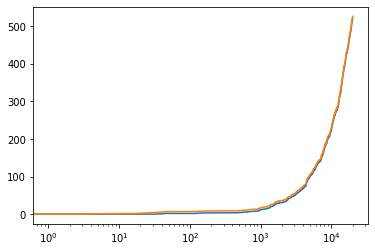

In [62]:
r_6_fair_ts = quickTest(1, FairTSAgent)

# Surplus based Curiosity

In [63]:
class SurplusCurUCBAgent(Agent):
    def __init__(self, envr, rounds):
        Agent.__init__(self, envr, rounds)
        upper_conf_bound = []
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        
        if len(self.envr.arms) == 0:
            self.envr.pullNewArm()
            return
        
        # Weighting on surplus
        hypothetical_best = 1
        predicted_qualities = [None] * len(available_arms)
        for i in range(len(available_arms)):
            s_i = available_arms[i].num_rewards
            n_i = available_arms[i].num_pulled
            a = (s_i/(n_i))
            predicted_qualities[i]=a
        current_best = max(predicted_qualities)
        surplus = hypothetical_best - current_best
        
        
        if uniform.rvs(size=1)[0] < 0.005 * surplus:
            self.envr.pullNewArm()
        else:
            upper_conf_bound = [None] * len(available_arms)
            for i in range(len(available_arms)):
                s_i = available_arms[i].num_rewards
                n_i = available_arms[i].num_pulled
                a = (s_i/(n_i))
                b = (8 * math.log10(self.total_rounds+1))/(n_i)
                r = (a + math.sqrt(b))

                upper_conf_bound[i]=(r)
            
            max_smpl = max(upper_conf_bound)
            max_i = upper_conf_bound.index(max_smpl)
            self.envr.pull(self.envr.arms[max_i])

Number of rounds: 20000
number of arms explored: 25
Regret wrt explored arms 1326.103593820471
Regret wrt to unexplored arms 1576.2022341346615


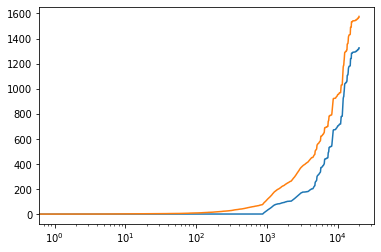

In [64]:
r_7_sur_ucb = quickTest(1, SurplusCurUCBAgent)

In [65]:
class SurplusCurTSAgent(Agent):
    def __init__(self, envr, rounds):
        Agent.__init__(self, envr, rounds)
        upper_conf_bound = []
    
    def playRound(self):
        self.round += 1
        available_arms = self.envr.arms
        
        if len(self.envr.arms) == 0:
            self.envr.pullNewArm()
            return
        
        # Weighting on surplus
        hypothetical_best = 1
        predicted_qualities = [None] * len(available_arms)
        for i in range(len(available_arms)):
            s_i = available_arms[i].num_rewards
            n_i = available_arms[i].num_pulled
            a = (s_i/(n_i))
            predicted_qualities[i]=a
        current_best = max(predicted_qualities)
        surplus = hypothetical_best - current_best
        
        
        if uniform.rvs(size=1)[0] < 0.005 * surplus:
            self.envr.pullNewArm()
        else:
            thm_smpl = [None] * len(available_arms)
            for i in range(len(available_arms)):
                s_i = available_arms[i].num_rewards
                n_i = available_arms[i].num_pulled
                a = s_i + 1
                b = n_i - s_i + 1
                
                #print("a,b", a, b)
                r = beta.rvs(a, b, size=1)
                thm_smpl[i]=r[0]
                
                #upper_conf_bound[i]=(r)
            
            max_smpl = max(thm_smpl)
            max_i = thm_smpl.index(max_smpl)
            self.envr.pull(self.envr.arms[max_i])

Number of rounds: 20000
number of arms explored: 11
Regret wrt explored arms 26.797727108834998
Regret wrt to unexplored arms 42.92537024577706


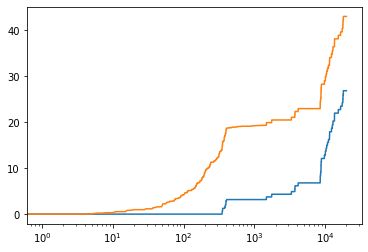

In [66]:
r_8_sur_ts = quickTest(1, SurplusCurTSAgent)

# All graphs together

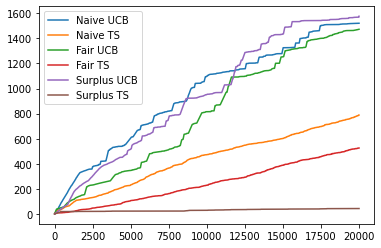

In [67]:
#r_1_random, r_2_new, r_3_naive_ucb, r_4_naive_ts, r_5_fair_ucb, r_6_fair_ts, r_7_sur_ucb, r_8_sur_ts

import matplotlib.pyplot as plt
time_hor = range(DEFAULT_TEST_ROUNDS)
#plt.plot(time_hor, r_1_random, label="Random")
#plt.plot(time_hor, r_1_random, label="Always New")

plt.plot(time_hor, r_3_naive_ucb, label="Naive UCB")
plt.plot(time_hor, r_4_naive_ts, label="Naive TS")

plt.plot(time_hor, r_5_fair_ucb, label="Fair UCB")
plt.plot(time_hor, r_6_fair_ts, label="Fair TS")

plt.plot(time_hor, r_7_sur_ucb, label="Surplus UCB")
plt.plot(time_hor, r_8_sur_ts, label="Surplus TS")
plt.legend()
plt.xscale("linear")
plt.yscale("linear")

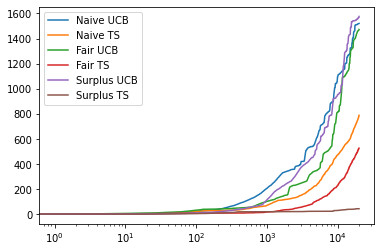

In [68]:
#r_1_random, r_2_new, r_3_naive_ucb, r_4_naive_ts, r_5_fair_ucb, r_6_fair_ts, r_7_sur_ucb, r_8_sur_ts

#import matplotlib.pyplot as plt
time_hor = range(DEFAULT_TEST_ROUNDS)
#plt.plot(time_hor, r_1_random, label="Random")
#plt.plot(time_hor, r_1_random, label="Always New")

plt.plot(time_hor, r_3_naive_ucb, label="Naive UCB")
plt.plot(time_hor, r_4_naive_ts, label="Naive TS")

plt.plot(time_hor, r_5_fair_ucb, label="Fair UCB")
plt.plot(time_hor, r_6_fair_ts, label="Fair TS")

plt.plot(time_hor, r_7_sur_ucb, label="Surplus UCB")
plt.plot(time_hor, r_8_sur_ts, label="Surplus TS")
plt.legend()
plt.xscale("log")
plt.yscale("linear")

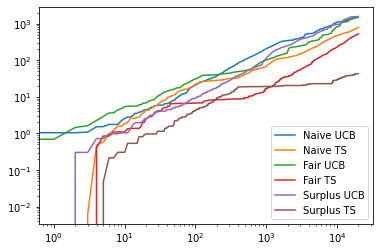

In [69]:
#r_1_random, r_2_new, r_3_naive_ucb, r_4_naive_ts, r_5_fair_ucb, r_6_fair_ts, r_7_sur_ucb, r_8_sur_ts

#import matplotlib.pyplot as plt
time_hor = range(DEFAULT_TEST_ROUNDS)
#plt.plot(time_hor, r_1_random, label="Random")
#plt.plot(time_hor, r_1_random, label="Always New")

plt.plot(time_hor, r_3_naive_ucb, label="Naive UCB")
plt.plot(time_hor, r_4_naive_ts, label="Naive TS")

plt.plot(time_hor, r_5_fair_ucb, label="Fair UCB")
plt.plot(time_hor, r_6_fair_ts, label="Fair TS")

plt.plot(time_hor, r_7_sur_ucb, label="Surplus UCB")
plt.plot(time_hor, r_8_sur_ts, label="Surplus TS")
plt.legend()
plt.xscale("log")
plt.yscale("log")